## Home Loan Application Analysis using Aequitas
<a id='top_cell'></a>
Recent work in the Machine Learning community has raised concerns about the risk of unintended bias in Algorithmic Decision-Making systems, affecting individuals unfairly. While many bias metrics and fairness definitions have been proposed in recent years, the community has not reached a consensus on which definitions and metrics should be used, and there has been very little empirical analyses of real-world problems using the proposed metrics.

We present the Aequitas toolkit as an intuitive addition to the machine learning workflow, enabling users to to seamlessly test models for several bias and fairness metrics in relation to multiple population groups. We believe the tool will faciliate informed and equitable decision-making around developing and deploying predictive risk-assessment tools for both machine learnining practitioners and policymakers, allowing researchers and program managers to answer a host of questions related to machine learning models, including:

- [What biases exist in my model?](#existing_biases)
    - [What is the distribution of groups, predicted scores, and labels across my dataset?](#xtab)
    - [What are bias metrics across groups?](#xtab_metrics)
    - [How do I interpret biases in my model?](#interpret_bias)
    - [How do I visualize biases in my model?](#bias_viz)

- [What levels of disparity exist between population groups?](#disparities)
    - [How does the selected reference group affect disparity calculations?](#disparity_calc)
    - [How do I interpret calculated disparity ratios?](#interpret_disp)
    - [How do I visualize disparities in my model?](#disparity_viz)

- [How do I assess model fairness??](#fairness)
    - [How do I interpret parities?](#interpret_fairness)
    - [How do I visualize bias metric parity?](#fairness_group_viz)
    - [How do I visualize parity between groups in my model?](#fairness_disp_viz)


We apply the Use case pf the home loan appöication dataset from kaggle.

### Background

The dataset contains information on 614 loan applications, with 13 features including gender, marital status, income, loan amount, credit history, and loan status (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset). The goal is to build a predictive model to determine the likelihood of loan approval.

#### Problem Statement
Dreamhouse Loan Company specializes in providing various types of loans across urban, semi-urban, and rural areas. When a loan application is received, the company validates the applicant’s eligibility based on details such as gender, marital status, educatio lecel, income, loan amount, and credit history (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset). The objective is to streamline and automate this process to identify eligible customer segments and optimize loan offerings (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset).

#### History
The dataset is part of a broader effort to improve the loan approval process by leveraging data analytics and machine learning. It has been used in various predictive modeling projects to enhance the accuracy and efficiency of loan eligibility assessments (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset). 

In [1]:
!pip install "aequitas==1.0.0" &> /dev/null

import pandas as pd
import seaborn as sns
from aequitas.audit import Audit
from aequitas.fairness import Fairness
import aequitas.plot as ap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from IPython.display import Markdown, display
# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:
from helpers.mlp_prediction import *

datasetX, dataset ,target, numerical, categorical = load_and_preprocess_data('/Users/nilsness/Desktop/Uni Skripte und Folien/Masterarbeit/Programming/Loan-Approval-Prediction.csv')

In [3]:
# Calculate the number of instances to remove
num_instances = int(0.75 * len(dataset[(dataset['Gender'] == 'Female') & (dataset['Loan_Status'] == 'Y')]))

# Get the indices of the instances to remove
indices_to_remove = dataset[(dataset['Gender'] == 'Female') & (dataset['Loan_Status'] == 'Y')].sample(num_instances).index

# Remove the instances from the dataset
dataset = dataset.drop(indices_to_remove)

target = dataset['Loan_Status']
datasetX = dataset.drop(columns=['Loan_Status'])
dataset


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [4]:
x_train_encoded, x_test_encoded, y_train, y_test, Z_train, Z_test, datasetX1, target,Z, dataset_num_headers, scaler, encoder = do_it_like_numbers_do(dataset.drop(columns='Loan_Status'),target,numerical, categorical)

In [5]:
dataset_num_headers

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area,Property_Area_Urban
1,1,1,1,0,0,0.054830,0.044567,0.201354,0.729730,1,1,0,0
2,1,1,0,0,1,0.035250,0.000000,0.096447,0.729730,1,0,0,1
3,1,1,0,1,0,0.030093,0.069687,0.187817,0.729730,1,0,0,1
4,1,0,0,0,0,0.072356,0.000000,0.223350,0.729730,1,0,0,1
5,1,1,2,0,1,0.065145,0.124006,0.436548,0.729730,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,1,1,0,0,0,0.038120,0.057629,0.167513,0.729730,1,1,0,0
610,1,1,3,0,0,0.048930,0.000000,0.052453,0.324324,1,1,0,0
611,1,1,1,0,0,0.097984,0.007093,0.412860,0.729730,1,0,0,1
612,1,1,2,0,0,0.091936,0.000000,0.301184,0.729730,1,0,0,1


In [6]:
predictions = pd.read_csv('/Users/nilsness/Desktop/Uni Skripte und Folien/Masterarbeit/Programming/MISC/predictions_undersampled.csv')
predictions

,Unnamed: 0,Prediction
0,0,0.767943
1,1,0.792521
2,2,0.704106
3,3,0.558845
4,4,0.720355
...,...,...
435,435,0.785631
436,436,0.811045
437,437,0.773082
438,438,0.817006


In [7]:
prediction_rounded = np.where(predictions['Prediction'] > 0.5, int(1), int(0))
prediction_rounded

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,

In [8]:
dataset['Predictions']=prediction_rounded

In [9]:
dataset['Predictions']

1      1
2      1
3      1
4      1
5      1
      ..
608    1
610    1
611    1
612    1
613    0
Name: Predictions, Length: 440, dtype: int64

Accuracy: 0.6386363636363637
Precision: 0.6852367688022284
Recall: 0.8424657534246576
F1-Score: 0.7557603686635944


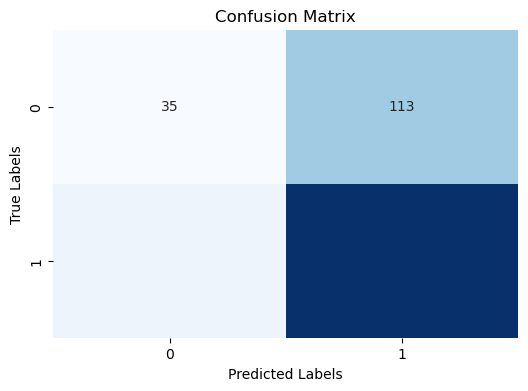

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = dataset['Loan_Status'].replace({'Y': 1, 'N': 0})
y_pred = dataset['Predictions']

# Berechnung der Genauigkeit
accuracy = accuracy_score(y_test, y_pred)

# Berechnung der Präzision
precision = precision_score(y_test, y_pred)

# Berechnung des Recall
recall = recall_score(y_test, y_pred)

# Berechnung des F1-Scores
f1 = f1_score(y_test, y_pred)
# Berechnung der Ks =_(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)



import matplotlib.pyplot as plt


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [11]:
df = dataset.copy()


In [12]:
df.replace({'Loan_Status': {'Y': 1, 'N': 0}}, inplace=True)

In [13]:

# Annahme: Ihr DataFrame heißt "df" und die Spalte mit der Kreditgenehmigungsrate heißt "Loan_Status"

# Durchschnittliche Kreditgenehmigungsrate nach Geschlecht
avg_approval_rate_gender = df.groupby('Gender')['Loan_Status'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand
avg_approval_rate_education = df.groupby('Education')['Loan_Status'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich
avg_approval_rate_property = df.groupby('Property_Area')['Loan_Status'].mean()

avg_approval_marital_property = df.groupby('Married')['Loan_Status'].mean()
avg_approval_Dependents_property = df.groupby('Dependents')['Loan_Status'].mean()
avg_approval_Self_Employed_property = df.groupby('Self_Employed')['Loan_Status'].mean()
avg_approval_Credit_History_property = df.groupby('Credit_History')['Loan_Status'].mean()






# Durchschnittliche Kreditgenehmigungsrate nach anderen Variablen
# ...

# Ausgabe der Ergebnisse
print("Durchschnittliche Kreditgenehmigungsrate nach Geschlecht:")
print(avg_approval_rate_gender)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand:")
print(avg_approval_rate_education)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich:")
print(avg_approval_rate_property)
print()
print("\n\nDurchschnittliche Kreditgenehmigungsrate nach Marital:")
print(avg_approval_marital_property)
print("Durchschnittliche Kredit genehmigungsrate nach Dependents:") 
print(avg_approval_Dependents_property)
print("Durchschnittliche Kredit genehmigungsrate nach Self_Employed:")  
print(avg_approval_Self_Employed_property)
print("Kredit genehmigungsrate nach Credit_History:")   
print(avg_approval_Credit_History_property)
print() 
print("Durchschnittliche Kreditgenehmigungsrate nach numerischen Variablen:")

def aproval_rate_numerical(numerical,input_value):
    avg_approval_rate_numerical = (df[df[numerical] <= input_value].groupby(numerical)['Loan_Status']).mean()
    return avg_approval_rate_numerical.mean()

numerical_values ={'ApplicantIncome':2653,'CoapplicantIncome': 1500.0,'LoanAmount': 113.0,'Loan_Amount_Term': 180.0}

for key,value in numerical_values.items():
    print(f"{key}: {aproval_rate_numerical(key,value)}")


Durchschnittliche Kreditgenehmigungsrate nach Geschlecht:
Gender
Female    0.304348
Male      0.705584
Name: Loan_Status, dtype: float64

Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand:
Education
Graduate        0.68
Not Graduate    0.60
Name: Loan_Status, dtype: float64

Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich:
Property_Area
Rural        0.584615
Semiurban    0.751479
Urban        0.631206
Name: Loan_Status, dtype: float64



Durchschnittliche Kreditgenehmigungsrate nach Marital:
Married
No     0.546099
Yes    0.719064
Name: Loan_Status, dtype: float64
Durchschnittliche Kredit genehmigungsrate nach Dependents:
Dependents
0     0.640496
1     0.621622
2     0.759036
3+    0.682927
Name: Loan_Status, dtype: float64
Durchschnittliche Kredit genehmigungsrate nach Self_Employed:
Self_Employed
No     0.670185
Yes    0.622951
Name: Loan_Status, dtype: float64
Kredit genehmigungsrate nach Credit_History:
Credit_History
0.0    0.086957
1.0    0.770889
Name: 

In [17]:
# Durchschnittliche Kreditgenehmigungsrate nach Geschlecht
avg_approval_rate_gender = df.groupby('Gender')['Predictions'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand
avg_approval_rate_education = df.groupby('Education')['Predictions'].mean()

# Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich
avg_approval_rate_property = df.groupby('Property_Area')['Predictions'].mean()

avg_approval_marital_property = df.groupby('Married')['Predictions'].mean()
avg_approval_Dependents_property = df.groupby('Dependents')['Predictions'].mean()
avg_approval_Self_Employed_property = df.groupby('Self_Employed')['Predictions'].mean()
avg_approval_Credit_History_property = df.groupby('Credit_History')['Predictions'].mean()






# Durchschnittliche Kreditgenehmigungsrate nach anderen Variablen
# ...

# Ausgabe der Ergebnisse
print("Durchschnittliche Kreditgenehmigungsrate nach Geschlecht:")
print(avg_approval_rate_gender)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand:")
print(avg_approval_rate_education)
print()

print("Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich:")
print(avg_approval_rate_property)
print()
print("\n\nDurchschnittliche Kreditgenehmigungsrate nach Marital:")
print(avg_approval_marital_property)
print("Durchschnittliche Kredit genehmigungsrate nach Dependents:") 
print(avg_approval_Dependents_property)
print("Durchschnittliche Kredit genehmigungsrate nach Self_Employed:")  
print(avg_approval_Self_Employed_property)
print("Kredit genehmigungsrate nach Credit_History:")   
print(avg_approval_Credit_History_property)
print() 
print("Durchschnittliche Kreditgenehmigungsrate nach numerischen Variablen:")

def aproval_rate_numerical(numerical,input_value):
    avg_approval_rate_numerical = (df[df[numerical] <= input_value].groupby(numerical)['Predictions']).mean()
    return avg_approval_rate_numerical.mean()

numerical_values ={'ApplicantIncome':5500,'CoapplicantIncome': 0,'LoanAmount': 105.0}
numerical_over ={'Loan_Amount_Term': 360.0}

print('The following values are the approval rates for the numerical values and show the demographics of having this value or less')
for key,value in numerical_values.items():
    print(f"{key}: {aproval_rate_numerical(key,value)}")

print('The following values are the approval rates for the numerical values and show the demographics of having this value or more since the Term is a time period it is more likely that the higher the term the higher the approval rate.')
for key,value in numerical_over.items():
    print(f"{key}: {aproval_rate_numerical(key,value)}")

Durchschnittliche Kreditgenehmigungsrate nach Geschlecht:
Gender
Female    0.739130
Male      0.824873
Name: Predictions, dtype: float64

Durchschnittliche Kreditgenehmigungsrate nach Bildungsstand:
Education
Graduate        0.822857
Not Graduate    0.788889
Name: Predictions, dtype: float64

Durchschnittliche Kreditgenehmigungsrate nach Eigentumsbereich:
Property_Area
Rural        0.800000
Semiurban    0.863905
Urban        0.773050
Name: Predictions, dtype: float64



Durchschnittliche Kreditgenehmigungsrate nach Marital:
Married
No     0.801418
Yes    0.822742
Name: Predictions, dtype: float64
Durchschnittliche Kredit genehmigungsrate nach Dependents:
Dependents
0     0.814050
1     0.864865
2     0.855422
3+    0.658537
Name: Predictions, dtype: float64
Durchschnittliche Kredit genehmigungsrate nach Self_Employed:
Self_Employed
No     0.815303
Yes    0.819672
Name: Predictions, dtype: float64
Kredit genehmigungsrate nach Credit_History:
Credit_History
0.0    0.782609
1.0    0.82210

## Pre-Aequitas: Exploring the Loan Application

__loan assessment assessment by Gender__



In [51]:
aq_palette = sns.diverging_palette(225, 35, n=2)

In [52]:
df=dataset
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Predictions
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,1
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,1
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,1


In [53]:
df.Property_Area.unique()

array(['Rural', 'Urban', 'Semiurban'], dtype=object)

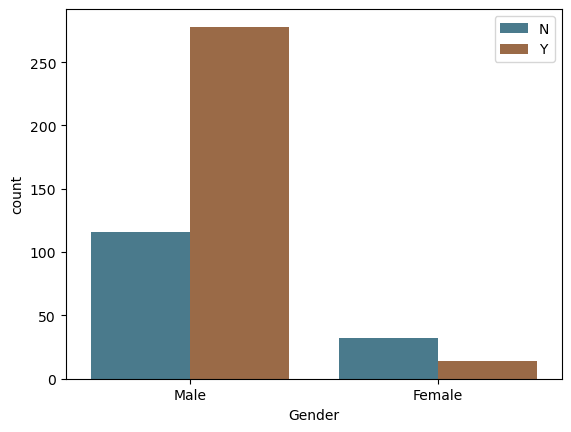

In [54]:
gender_plot = sns.countplot(x="Gender", hue="Loan_Status", data=df[df.Gender.isin(['Male', 'Female'])], palette=aq_palette)
plt.legend(loc='upper right')

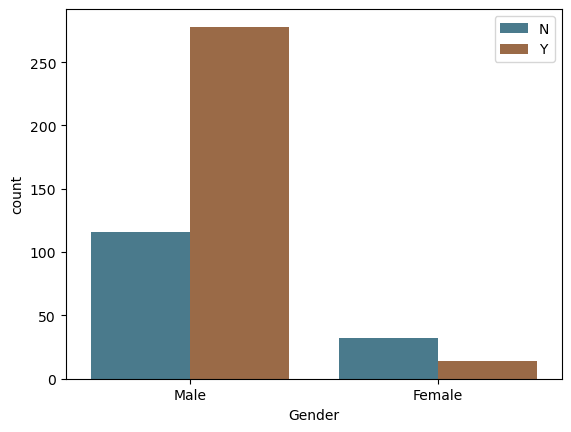

In [55]:


by_gender = sns.countplot(x="Gender", hue="Loan_Status", data=df[df.Gender.isin(['Male', 'Female'])], palette=aq_palette)
plt.legend(loc='upper right')


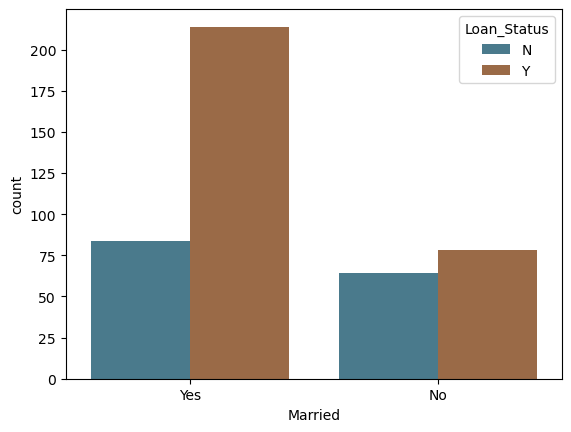

In [56]:
by_marriage = sns.countplot(x="Married", hue="Loan_Status", data=df, palette=aq_palette)

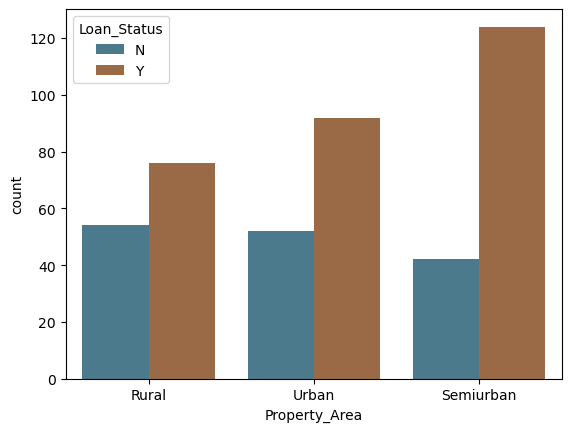

In [57]:
by_property = sns.countplot(x="Property_Area", hue="Loan_Status", data=df, palette=aq_palette)

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race.

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"




AttributeError: 'numpy.int64' object has no attribute 'startswith'

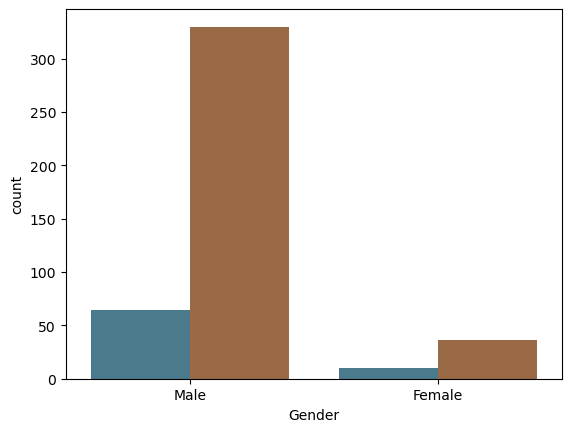

In [59]:
label_by_gender = sns.countplot(x="Gender", hue="Predictions", data=df[df.Gender.isin(['Male', 'Female'])], palette=aq_palette)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

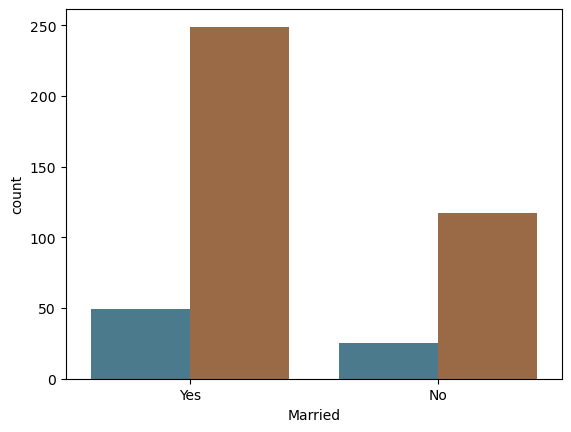

In [60]:
label_by_marital = sns.countplot(x="Married", hue="Predictions", data=df, palette=aq_palette)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

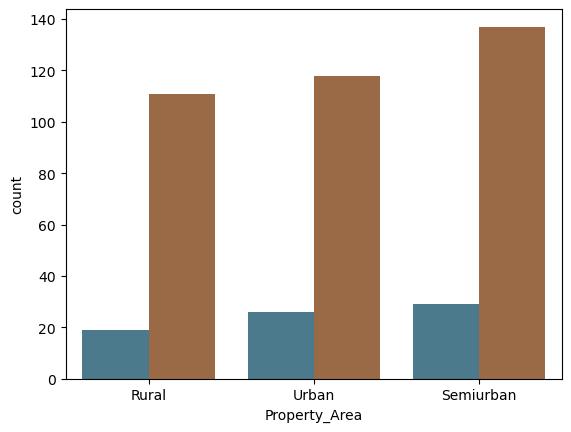

In [61]:
label_by_sex = sns.countplot(x="Property_Area", hue="Predictions", data=df, palette=aq_palette)

## Putting Aequitas to the task

The graphs above show the base rates for loan approvals are higher for male applicants compared to female applicants, though the predictions do not match the base rates.

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that there are multiple ways to measure bias adds complexity to the decision-making process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes:

`Group()`: Define groups

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


### Data Formatting

Data for this example was preprocessed for compatibility with Aequitas. **The Aequitas tool always requires a `score` column and requires a binary `label_value` column for supervised metrics**, (i.e., False Discovery Rate, False Positive Rate, False Omission Rate, and False Negative Rate).

Preprocessing includes but is not limited to checking for mandatory `score` and `label_value` columns as well as at least one column representing attributes specific to the data set. See [documentation](../input_data.html) for more information about input data.

Note that while `entity_id` is not necessary for this example, Aequitas recognizes `entity_id` as a reserve column name and will not recognize it as an attribute column.

[Back to Top](#top_cell)
<a id='existing_biases'></a>

## What biases exist in my model?

### _Aequitas Group() Class_

<a id='xtab'></a>

### What is the distribution of groups, predicted scores, and labels across my dataset?

Aequitas's `Group()` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population.

<a id='counts_description'></a>
The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Group Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' |
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


**Note**: The **`get_crosstabs()`** method expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include `gender`,and `Property_area`.

In [62]:
df.rename(columns={'Loan_Status': 'label_value'}, inplace=True)
df.rename(columns={'Predictions': 'score'}, inplace=True)
df['label_value'].replace({'Y': 1, 'N': 0}, inplace=True)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,label_value,score
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,1
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,1
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,1,1
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1,1
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1,1


In [63]:
df['Credit_History'] = df['Credit_History'].replace({1.0: 'Yes', 0.0: 'No'})


In [64]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,label_value,score
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Yes,Rural,0,1
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Yes,Urban,1,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Yes,Urban,1,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Yes,Urban,1,1
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,Yes,Urban,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,Yes,Rural,1,1
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,Yes,Rural,1,1
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,Yes,Urban,1,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,Yes,Urban,1,1


In [65]:
numerical =['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


audit = Audit(df.drop(columns=numerical), label_column="label_value")
audit.audit()

[Back to Top](#top_cell)
<a id='xtab_metrics'></a>

### What are bias metrics across groups?

Once you have run the `Group()` class **`get_crosstabs()`** method, you'll have a dataframe of the [group counts](#counts_description) and [group value bias metrics](#counts_description).

The `Group()` class has a **`list_absolute_metrics()`** method, which you can use for faster slicing to view just  counts or bias metrics.

#### View calculated counts across sample population groups

In [66]:
audit.confusion_matrix

pp  pn  fp  fn  tn   tp  group_label_pos  \
attribute_name attribute_value                                              
Gender         Female            36  10  22   0  10   14               14   
               Male             330  64  92  40  24  238              278   
Married        No               117  25  49  10  15   68               78   
               Yes              249  49  65  30  19  184              214   
Dependents     0                201  38  67  18  20  134              152   
               1                 58  19  20  11   8   38               49   
               2                 73  11  18   9   2   55               64   
               3+                34   6   9   2   4   25               27   
Education      Graduate         297  53  90  31  22  207              238   
               Not Graduate      69  21  24   9  12   45               54   
Self_Employed  No               320  60  98  33  27  222              255   
               Yes               46  14  16   7   7   30               37   
Credit_History No                42  27  38   2  25    4                6   
               Yes              324  47  76  38   9  248              286   
Property_Area  Rural            111  19  45  10   9   66               76   
               Semiurban        137  29  32  19  10  105              124   
               Urban            118  26  37  11  15   81               92   

                                group_label_neg  group_size  total_entities  
attribute_name attribute_value                                               
Gender         Female                        32          46             440  
               Male                         116         394             440  
Married        No                            64         142             440  
               Yes                           84         298             440  
Dependents     0                             87         239             440  
               1                             28          77             440  
               2                             20          84             440  
               3+                            13          40             440  
Education      Graduate                     112         350             440  
               Not Graduate                  36          90             440  
Self_Employed  No                           125         380             440  
               Yes                           23          60             440  
Credit_History No                            63          69             440  
               Yes                           85         371             440  
Property_Area  Rural                         54         130             440  
               Semiurban                     42         166             440  
               Urban                         52         144             440

#### View calculated absolute metrics for each sample population group

In [67]:
audit.metrics.round(2)

accuracy   tpr   tnr   for   fdr   fpr   fnr  \
attribute_name attribute_value                                                 
Gender         Female               0.52  1.00  0.31  0.00  0.61  0.69  0.00   
               Male                 0.66  0.86  0.21  0.62  0.28  0.79  0.14   
Married        No                   0.58  0.87  0.23  0.40  0.42  0.77  0.13   
               Yes                  0.68  0.86  0.23  0.61  0.26  0.77  0.14   
Dependents     0                    0.64  0.88  0.23  0.47  0.33  0.77  0.12   
               1                    0.60  0.78  0.29  0.58  0.34  0.71  0.22   
               2                    0.68  0.86  0.10  0.82  0.25  0.90  0.14   
               3+                   0.72  0.93  0.31  0.33  0.26  0.69  0.07   
Education      Graduate             0.65  0.87  0.20  0.58  0.30  0.80  0.13   
               Not Graduate         0.63  0.83  0.33  0.43  0.35  0.67  0.17   
Self_Employed  No                   0.66  0.87  0.22  0.55  0.31  0.78  0.13   
               Yes                  0.62  0.81  0.30  0.50  0.35  0.70  0.19   
Credit_History No                   0.42  0.67  0.40  0.07  0.90  0.60  0.33   
               Yes                  0.69  0.87  0.11  0.81  0.23  0.89  0.13   
Property_Area  Rural                0.58  0.87  0.17  0.53  0.41  0.83  0.13   
               Semiurban            0.69  0.85  0.24  0.66  0.23  0.76  0.15   
               Urban                0.67  0.88  0.29  0.42  0.31  0.71  0.12   

                                 npv  precision   ppr  pprev  prev  
attribute_name attribute_value                                      
Gender         Female           1.00       0.39  0.10   0.78  0.30  
               Male             0.38       0.72  0.90   0.84  0.71  
Married        No               0.60       0.58  0.32   0.82  0.55  
               Yes              0.39       0.74  0.68   0.84  0.72  
Dependents     0                0.53       0.67  0.55   0.84  0.64  
               1                0.42       0.66  0.16   0.75  0.64  
               2                0.18       0.75  0.20   0.87  0.76  
               3+               0.67       0.74  0.09   0.85  0.68  
Education      Graduate         0.42       0.70  0.81   0.85  0.68  
               Not Graduate     0.57       0.65  0.19   0.77  0.60  
Self_Employed  No               0.45       0.69  0.87   0.84  0.67  
               Yes              0.50       0.65  0.13   0.77  0.62  
Credit_History No               0.93       0.10  0.11   0.61  0.09  
               Yes              0.19       0.77  0.89   0.87  0.77  
Property_Area  Rural            0.47       0.59  0.30   0.85  0.58  
               Semiurban        0.34       0.77  0.37   0.83  0.75  
               Urban            0.58       0.69  0.32   0.82  0.64

[Back to Top](#top_cell)
<a id='interpret_bias'></a>

### How do I interpret biases in my model?
In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that Females have a false positive rate (`fpr`) of 69%, while Males have a false positive rate of 79%. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much further away for those two groups.

[Back to Top](#top_cell)
<a id='disparities'></a>

## What levels of disparity exist between population groups?

### _Aequitas Bias() Class_
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for female defendants vis-a-vis males is:
$$Disparity_{FNR} =  \frac{FNR_{female}}{FNR_{male}}$$

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner.

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below.

#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

#### Disparities calculated in relation to a user-specified group for each attribute

In [71]:
audit = Audit(df.drop(columns=numerical), label_column="label_value",
              reference_groups={'Gender':'Male', 'Married':'Yes','Dependents':'0','Education':'Graduate', 'Self_Employed':'No','Property_Area':'Semiurban','Credit_History':'Yes'})

audit.audit(bias_args={
    "alpha": 0.05,
    "check_significance": True,
    "mask_significance": True
})

audit.disparity_df.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,366,Gender,Female,0.521739,1.000000,0.312500,0.000000,0.611111,0.687500,0.000000,1.000000,0.388889,36,10,0.098361,0.782609,22,0,10,14,14,32,46,440,0.304348,True,False,2.192029,Male,True,0.000000,Male,True,0.000000,Male,True,0.866848,Male,True,2.666667,Male,True,0.109091,Male,False,0.934387,Male,False,0.539216,Male,True,1.510417,Male,True,1.168067,Male,True
1,0,binary 0/1,366,Gender,Male,0.664975,0.856115,0.206897,0.625000,0.278788,0.793103,0.143885,0.375000,0.721212,330,64,0.901639,0.837563,92,40,24,238,278,116,394,440,0.705584,False,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False
2,0,binary 0/1,366,Married,No,0.584507,0.871795,0.234375,0.400000,0.418803,0.765625,0.128205,0.600000,0.581197,117,25,0.319672,0.823944,49,10,15,68,78,64,142,440,0.549296,True,True,1.604339,Yes,True,0.914530,Yes,True,0.653333,Yes,True,0.989423,Yes,True,1.547368,Yes,True,0.469880,Yes,True,0.986085,Yes,True,0.786511,Yes,True,1.036184,Yes,True,1.013935,Yes,True
3,0,binary 0/1,366,Married,Yes,0.681208,0.859813,0.226190,0.612245,0.261044,0.773810,0.140187,0.387755,0.738956,249,49,0.680328,0.835570,65,30,19,184,214,84,298,440,0.718121,False,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False
4,0,binary 0/1,366,Dependents,0,0.644351,0.881579,0.229885,0.473684,0.333333,0.770115,0.118421,0.526316,0.666667,201,38,0.549180,0.841004,67,18,20,134,152,87,239,440,0.635983,False,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False
5,0,binary 0/1,366,Dependents,1,0.597403,0.775510,0.285714,0.578947,0.344828,0.714286,0.224490,0.421053,0.655172,58,19,0.158470,0.753247,20,11,8,38,49,28,77,440,0.636364,False,False,1.034483,0,False,1.895692,0,False,1.222222,0,False,0.927505,0,False,0.800000,0,False,0.288557,0,False,0.895652,0,False,0.982759,0,False,1.242857,0,False,0.879683,0,False
6,0,binary 0/1,366,Dependents,2,0.678571,0.859375,0.100000,0.818182,0.246575,0.900000,0.140625,0.181818,0.753425,73,11,0.199454,0.869048,18,9,2,55,64,20,84,440,0.761905,True,False,0.739726,0,False,1.187500,0,True,1.727273,0,True,1.168657,0,False,0.345455,0,True,0.363184,0,False,1.033345,0,False,1.130137,0,False,0.435000,0,False,0.974813,0,True
7,0,binary 0/1,366,Dependents,3+,0.725000,0.925926,0.307692,0.333333,0.264706,0.692308,0.074074,0.666667,0.735294,34,6,0.092896,0.850000,9,2,4,25,27,13,40,440,0.675000,False,False,0.794118,0,False,0.625514,0,False,0.703704,0,False,0.898967,0,False,1.266667,0,False,0.169154,0,False,1.010697,0,False,1.102941,0,False,1.338462,0,False,1.050304,0,False
8,0,binary 0/1,366,Education,Graduate,0.654286,0.869748,0.196429,0.584906,0.303030,0.803571,0.130252,0.415094,0.696970,297,53,0.811475,0.848571,90,31,22,207,238,112,350,440,0.680000,False,False,1.000000,Graduate,False,1.000000,Graduate,False,1.000000,Graduate,False,1.000000,Graduate,False,1.000000,Graduate,False,1.000000

In [72]:
bdf = audit.disparity_df

The `Bias()` class includes a method to quickly return a list of calculated disparities from the dataframe returned by the **`get_disparity_`** methods.

In [73]:
audit.disparities.style

In [74]:
metrics = ['fpr','fdr','ppr','pprev']
disparity_tolerance = 1.5

# Aequitas Visualizations

In [75]:
audit.summary_plot(metrics=metrics, fairness_threshold=disparity_tolerance)

alt.VConcatChart(...)

### Check for disparities in Gender

In [76]:
audit.disparity_plot(metrics=metrics, attribute='Gender', fairness_threshold=disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [77]:
ap.absolute(bdf, metrics, 'Gender', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

### Check for disparities in Sex

In [78]:
ap.disparity(bdf, metrics, 'Married', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [79]:
ap.absolute(bdf, metrics, 'Property_Area', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

### Check for disparities in Education, Self_Employed and Dependents

In [80]:
ap.disparity(bdf, metrics, 'Education', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [81]:
ap.absolute(bdf, metrics, 'Dependents', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

In [82]:
ap.absolute(bdf, metrics, 'Self_Employed', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

[Back to Top](#top_cell)
<a id='interpret_disp'></a>

### How do I interpret calculated disparity ratios?
The calculated disparities from the dataframe returned by the `Bias()` class **`get_disparity_`** methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the `Group()` class above, are clarified using the disparity ratio (`fpr_disparity`).

As seen above, False Discovery Rates have a higher disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the `fdr_disparity` value close to 2.21 for the gender attribute group 'Female' when disparities are calculated using predefined base group 'Male'.

[Back to Top](#top_cell)
<a id='disparity_calc'></a>

### How does the selected reference group affect disparity calculations?

Disparities calculated in the the Aequitas `Bias()` class based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

In [83]:
from aequitas.group import Group
from aequitas.bias import Bias
b = Bias()
g = Group()
xx = df.drop(columns=numerical)
xtab, _ = g.get_crosstabs(xx)
xx
x_copy = xx.copy()

In [84]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,366,Gender,Female,0.521739,1.000000,0.312500,0.000000,0.611111,...,0.782609,22,0,10,14,14,32,46,440,0.304348
1,0,binary 0/1,366,Gender,Male,0.664975,0.856115,0.206897,0.625000,0.278788,...,0.837563,92,40,24,238,278,116,394,440,0.705584
2,0,binary 0/1,366,Married,No,0.584507,0.871795,0.234375,0.400000,0.418803,...,0.823944,49,10,15,68,78,64,142,440,0.549296
3,0,binary 0/1,366,Married,Yes,0.681208,0.859813,0.226190,0.612245,0.261044,...,0.835570,65,30,19,184,214,84,298,440,0.718121
4,0,binary 0/1,366,Dependents,0,0.644351,0.881579,0.229885,0.473684,0.333333,...,0.841004,67,18,20,134,152,87,239,440,0.635983
5,0,binary 0/1,366,Dependents,1,0.597403,0.775510,0.285714,0.578947,0.344828,...,0.753247,20,11,8,38,49,28,77,440,0.636364
6,0,binary 0/1,366,Dependents,2,0.678571,0.859375,0.100000,0.818182,0.246575,...,0.869048,18,9,2,55,64,20,84,440,0.761905
7,0,binary 0/1,366,Dependents,3+,0.725000,0.925926,0.307692,0.333333,0.264706,...,0.850000,9,2,4,25,27,13,40,440,0.675000
8,0,binary 0/1,366,Education,Graduate,0.654286,0.869748,0.196429,0.584906,0.303030,...,0.848571,90,31,22,207,238,112,350,440,0.680000
9,0,binary 0/1,366,Education,Not Graduate,0.633333,0.833333,0.333333,0.428571,0.347826,...,0.766667,24,9,12,45,54,36,90,440,0.600000


In [87]:
hbdf = b.get_disparity_predefined_groups(xtab, original_df=xx,
                                         ref_groups_dict={'Gender':'Male', 'Married':'Yes','Dependents':'0','Education':'Graduate', 'Self_Employed':'No','Property_Area':'Semiurban','Credit_History':'Yes'},
                                         alpha=0.05,
                                         check_significance=True,
                                         mask_significance=False,
                                         selected_significance=['fpr', 'for', 'fdr'])


In [88]:
# View disparity metrics added to dataframe
hbdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(hbdf) + b.list_significance(hbdf)]

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,for_significance,fpr_significance
0,Gender,Female,2.192029,0.000000,0.000000,0.866848,2.666667,0.109091,0.934387,0.539216,1.510417,1.168067,3.198700e-08,0.346821,3.753277e-05,4.793670e-15,3.753277e-05
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
2,Married,No,1.604339,0.914530,0.653333,0.989423,1.547368,0.469880,0.986085,0.786511,1.036184,1.013935,1.266939e-34,0.000049,9.634863e-20,1.494395e-12,9.634863e-20
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
5,Dependents,1,1.034483,1.895692,1.222222,0.927505,0.800000,0.288557,0.895652,0.982759,1.242857,0.879683,9.952053e-01,0.082030,8.709207e-01,4.625840e-01,8.709207e-01
6,Dependents,2,0.739726,1.187500,1.727273,1.168657,0.345455,0.363184,1.033345,1.130137,0.435000,0.974813,2.640837e-02,0.539150,1.711380e-01,4.402051e-02,1.711380e-01
7,Dependents,3+,0.794118,0.625514,0.703704,0.898967,1.266667,0.169154,1.010697,1.102941,1.338462,1.050304,6.353354e-01,0.885631,4.310094e-01,5.322131e-01,4.310094e-01
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
9,Education,Not Graduate,1.147826,1.279570,0.732719,0.829630,1.376623,0.232323,0.903479,0.935728,1.696970,0.958132,1.526379e-01,0.064145,4.705418e-01,2.293865e-01,4.705418e-01


#### Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute
The majority population groups for each attribute ('gender', 'property are', 'self employed') in the Home Loan application dataset are 'Male', 'Urban', and 'No'. Using the **`get_disparity_major_group()`** method of calculation allows researchers to quickly evaluate how much more (or less often) other groups are falsely or correctly missclasified as approved or denied in relation to the group they have the most data on.

In [89]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=xx)

In [90]:
majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Gender,Female,0.109091,0.934387,0.539216,2.192029,0.000000,0.866848,0.000000,1.168067,1.510417,2.666667
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Married,No,0.469880,0.986085,0.786511,1.604339,0.653333,0.989423,0.914530,1.013935,1.036184,1.547368
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,Dependents,1,0.288557,0.895652,0.982759,1.034483,1.222222,0.927505,1.895692,0.879683,1.242857,0.800000
6,Dependents,2,0.363184,1.033345,1.130137,0.739726,1.727273,1.168657,1.187500,0.974813,0.435000,0.345455
7,Dependents,3+,0.169154,1.010697,1.102941,0.794118,0.703704,0.898967,0.625514,1.050304,1.338462,1.266667
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,Education,Not Graduate,0.232323,0.903479,0.935728,1.147826,0.732719,0.829630,1.279570,0.958132,1.696970,1.376623


#### Disparities calculated in relation to the minimum value for each metric

When you do not have a pre-existing don’t frame of reference or policy context for the dataset (ex: Males or Not self-employed historically favored), you may choose to view disparities in relation to the group with the lowest value for every disparity metric, as then every group's value will be at least 1.0, and relationships can be evaluated more linearly.


Note that disparities are much more varied, and may have larger magnitude, when the minimum value per metric is used as a reference group versus one of the other two methods.

In [91]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=xx,
                                            check_significance=True)
min_metric_bdf.style

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,366,Gender,Female,0.521739,1.000000,0.312500,0.000000,0.611111,0.687500,0.000000,1.000000,0.388889,36,10,0.098361,0.782609,22,0,10,14,14,32,46,440,0.304348,False,False,2.192029,Male,True,nan,Female,None,nan,Female,None,1.000000,Female,False,2.666667,Male,True,1.000000,Female,False,1.000000,Female,False,1.000000,Female,False,1.510417,Male,True,1.168067,Male,True
1,0,binary 0/1,366,Gender,Male,0.664975,0.856115,0.206897,0.625000,0.278788,0.793103,0.143885,0.375000,0.721212,330,64,0.901639,0.837563,92,40,24,238,278,116,394,440,0.705584,True,False,1.000000,Male,False,10.000000,Female,True,10.000000,Female,True,1.153605,Female,True,1.000000,Male,False,9.166667,Female,False,1.070220,Female,False,1.854545,Female,True,1.000000,Male,False,1.000000,Male,False
2,0,binary 0/1,366,Married,No,0.584507,0.871795,0.234375,0.400000,0.418803,0.765625,0.128205,0.600000,0.581197,117,25,0.319672,0.823944,49,10,15,68,78,64,142,440,0.549296,False,False,1.604339,Yes,True,1.000000,No,True,1.000000,No,False,1.000000,No,False,1.547368,Yes,True,1.000000,No,False,1.000000,No,False,1.000000,No,False,1.036184,Yes,True,1.013935,Yes,False
3,0,binary 0/1,366,Married,Yes,0.681208,0.859813,0.226190,0.612245,0.261044,0.773810,0.140187,0.387755,0.738956,249,49,0.680328,0.835570,65,30,19,184,214,84,298,440,0.718121,True,True,1.000000,Yes,False,1.093458,No,False,1.530612,No,True,1.010690,No,True,1.000000,Yes,False,2.128205,No,True,1.014111,No,True,1.271439,No,True,1.000000,Yes,False,1.000000,Yes,True
4,0,binary 0/1,366,Dependents,0,0.644351,0.881579,0.229885,0.473684,0.333333,0.770115,0.118421,0.526316,0.666667,201,38,0.549180,0.841004,67,18,20,134,152,87,239,440,0.635983,False,False,1.351852,2,False,1.598684,3+,False,1.421053,3+,False,1.112388,3+,False,2.894737,2,True,5.911765,3+,False,1.116506,1,False,1.017544,1,False,2.298851,2,False,1.136773,1,False
5,0,binary 0/1,366,Dependents,1,0.597403,0.775510,0.285714,0.578947,0.344828,0.714286,0.224490,0.421053,0.655172,58,19,0.158470,0.753247,20,11,8,38,49,28,77,440,0.636364,False,False,1.398467,2,False,3.030612,3+,False,1.736842,3+,False,1.031746,3+,False,2.315789,2,False,1.705882,3+,False,1.000000,1,False,1.000000,1,False,2.857143,2,False,1.000000,1,False
6,0,binary 0/1,366,Dependents,2,0.678571,0.859375,0.100000,0.818182,0.246575,0.900000,0.140625,0.181818,0.753425,73,11,0.199454,0.869048,18,9,2,55,64,20,84,440,0.761905,False,False,1.000000,2,False,1.898438,3+,True,2.454545,3+,True,1.300000,3+,False,1.000000,2,False,2.147059,3+,False,1.153736,1,False,1.149964,1,False,1.000000,2,False,1.108141,1,False
7,0,binary 0/1,366,Dependents,3+,0.725000,0.925926,0.307692,0.333333,0.264706,0.692308,0.074074,0.666667,0.735294,34,6,0.092896,0.850000,9,2,4,25,27,13,40,440,0.675000,False,False,1.073529,2,False,1.000000,3+,False,1.000000,3+,False,1.000000,3+,False,3.666667,2,True,1.000000,3+,False,1.128448,1,False,1.122291,1,False,3.076923,2,False,1.193957,1,False
8,0,binary 0/1,366,Education,Graduate,0.654286,0.869748,0.196429,0.584906,0.303030,0.803571,0.130252,0.415094,0.696970,297,53,0.811475,0.848571,90,31,22,207,238,112,350,440,0.680000,False,False,1.000000,Graduate,False,1.000000,Graduate,False,1.364780,Not Graduate,False,1.205357,Not Graduate,False,1.000

[Back to Top](#top_cell)
<a id='disparity_viz'></a>

## How do I visualize disparities in my model?
To visualize disparities in the dataframe returned by one of the `Bias()` class **`get_disparity_`** methods use one of two methods in the Aequitas `Plot()` class:

A particular disparity metric can be specified with **`plot_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_disparity_all()`**.  At least one metric or at least one attribute must be specified when plotting multiple disparities (or the same disparity across multiple attributes). For example, to plot PPR and and Precision disparity for all attributes, specify `metrics=['ppr', 'precision']` with no attribute specified, and to plot default metrics by gender, specify `attributes=['gender']` and with no metrics specified.

**Reference groups are displayed in grey, and always have a disparity = 1.** Note that disparities greater than 10x reference group will are visualized as 10x, and disparities less than 0.1x reference group are visualized as 0.1x.

Statistical siginificance (at a default value of 0.05) is denoted by two asterisks (**) next to a treemap square's value.

In [48]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The `Fairness()` class includes a method to quickly return a list of fairness determinations from the dataframe returned by the **`get_group_value_fairness()`** method.

In [49]:
parity_detrminations = f.list_parities(fdf)


In [50]:
absolute_metrics= g.absolute_metrics(df=x_copy)


TypeError: 'tuple' object is not callable

In [51]:
fdf[['attribute_name', 'attribute_value'] + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,NPV Parity,TypeII Parity,TNR Parity,Statistical Parity,Equalized Odds,Unsupervised Fairness,FOR Parity,FNR Parity,Supervised Fairness,Precision Parity,TPR Parity,FPR Parity,FDR Parity,TypeI Parity,Impact Parity
0,Gender,Female,2.089646,0.461794,0.112701,0.755208,2.907692,0.099698,0.853934,0.554868,2.175000,1.098480,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,Married,No,1.528389,0.821238,0.565611,0.926471,1.923077,0.461847,0.979379,0.801489,1.312500,1.033580,False,False,False,False,True,False,False,True,False,True,True,True,False,False,True
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,Dependents,1,1.064591,1.066667,0.943590,0.973881,1.073333,0.294416,0.980043,0.966711,1.087500,0.986667,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True
6,Dependents,2,0.765283,0.857143,1.592308,1.233582,0.230000,0.370558,1.084888,1.120969,0.217500,1.028571,False,False,False,False,True,False,False,True,False,True,True,True,False,False,True
7,Dependents,3+,0.735075,0.214286,0.353846,0.898967,1.840000,0.182741,1.083075,1.136538,1.338462,1.157143,False,False,False,False,True,False,False,False,False,True,True,True,False,False,True
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
9,Education,Not Graduate,1.192175,1.002096,0.716049,0.898765,1.464646,0.242321,0.955670,0.914799,1.414141,0.999628,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True


[Back to Top](#top_cell)
<a id='interpret_fairness'></a>

### How do I interpret parities?
Calling the Aequitas `Fairness()` class **`get_group_value_fairness()`** method on the dataframe returned from a `Bias()` class `get_dispariy` method will return the dataframe with additional columns indicating parities, as seen in the slice of the `get_group_value_fairness` data frame directly above.

In this case, our base groups are Male for gender, Urban for property_area, and No for self_employed. By construction, the base group has supervised fairness. (The disparity ratio is 1).

Above, the Female false omission rate is within the bounds of fairness. This result is expected somewhat surprising as the model is just the plain MLPClassifier.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.

### Attribute Level Fairness
Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [52]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,Dependents,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False
1,0,binary 0/1,Education,False,True,True,True,False,True,True,False,False,True,True,False,True,False,False
2,0,binary 0/1,Gender,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
3,0,binary 0/1,Married,False,True,False,True,False,True,True,False,False,True,False,False,True,False,False
4,0,binary 0/1,Property_Area,True,True,False,True,False,False,True,False,False,False,False,False,True,True,False
5,0,binary 0/1,Self_Employed,False,True,True,True,True,False,True,False,True,True,True,False,True,False,False


### Overall Fairness
The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`**, returning a dictionary with a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [53]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

[Back to Top](#top_cell)